In [1]:
from IPython.core.display import display, HTML
%matplotlib inline

In [2]:
import collections 
from datetime import datetime

from IPython.display import display
from pyspark.sql import functions as fn

root_path = "/user/silva/output/fall"

patients_path = root_path + "patients"
diagnoses_path = root_path + "diagnoses"
drugs_path = root_path + "drug-purchases"
fractures_path = root_path + "fractures"

Dates = collections.namedtuple('dates', ['lower_bound', 'upper_bound'])
dates = Dates(
    lower_bound = datetime(2006, 1, 1, 0, 0, 0),
    upper_bound = datetime(2011, 1, 1, 0, 0, 0)
)

def filter_date(df):
    return df.where(
        (fn.col("start") >= fn.lit(dates.lower_bound))
        & (fn.col("start") < fn.lit(dates.upper_bound))
    )

drugs = filter_date(sqlContext.read.parquet(drugs_path)).cache()
diagnoses = filter_date(sqlContext.read.parquet(diagnoses_path)).cache()
fractures = filter_date(sqlContext.read.parquet(fractures_path))
events = drugs.union(diagnoses).cache()
patients = sqlContext.read.parquet(patients_path)

affected_patients = patients.join(fractures.select("patientID").distinct(), "patientID").cache()

print("affected patients: {}".format(affected_patients.count()))
display(events.agg(fn.min("start"), fn.max("start")).toPandas())

affected patients: 31662


,min(start),max(start)
0,2009-10-02,2010-12-31


In [3]:
from itertools import chain

class MyPatientsDF(object):
    
    def __init__(self, patients, cohort_name, reference_date=datetime(2015, 1, 1), max_age=150):
        self.patients = patients
        self.cohort_name = cohort_name
        self.reference_date = reference_date
        self.bucket_mapping = self._get_string_maps(max_age)
        
    def _get_string_maps(self, max_age):
        age_lists = range(0, max_age, 5)
        buckets = zip(age_lists[:-1], age_lists[1:])
        string_maps = {i: "[{}, {}[".format(bucket[0], bucket[1]) for (i, bucket) in enumerate(buckets)}
        return string_maps
        
        
    def _add_reference_date(self):
        self.patients = (
            self.patients.withColumn("referenceDate",
                                     fn.coalesce(fn.col("deathDate") , fn.lit(self.reference_date)))
            )
        
        
    def _add_age_in_months(self):
        try:
            self.patients = self.patients.withColumn("ageInMonths", fn.months_between(fn.col("referenceDate"), fn.col("birthDate"))) 
        except:
            self._add_reference_date()
            self.patients = self.patients.withColumn("ageInMonths", fn.months_between(fn.col("referenceDate"), fn.col("birthDate")))
        
    def add_age(self):
        try:
            self.patients = self.patients.withColumn("age", fn.expr("ageInMonths div 12"))
        except:
            self._add_age_in_months()
            self.patients = self.patients.withColumn("age", fn.expr("ageInMonths div 12"))
            
    def add_age_bucket(self):
        try:
            self.patients = self.patients.withColumn("ageBucket", fn.expr("ageInMonths div (12*5)"))
        except:
            self._add_age_in_months()
            self.patients = self.patients.withColumn("ageBucket", fn.expr("ageInMonths div (12*5)"))

In [4]:
from IPython.display import display

class Stats(object):
    
    def __init__(self, patientsDF: MyPatientsDF):
        self.patientsDF = patientsDF
        self.patientsDF.patients = self.patientsDF.patients.where(fn.col("ageBucket") > 12)
        
    def get_distribution_by(self, keys):
        return self.patientsDF.groupBy(*keys).count().alias("num_patients").toPandas()
    
    def get_distribution_by_age_bucket(self):
        agg_df = self.patientsDF.patients.groupBy("ageBucket").count().alias("num_patients").orderBy("ageBucket").toPandas()
        agg_df.ageBucket = agg_df.ageBucket.map(lambda x: self.patientsDF.bucket_mapping[x])
        return agg_df
    
    def get_distribution_by_gender(self):
        return self.patientsDF.patients.groupBy("gender").count().alias("num_patients").toPandas()
    
    def get_distribution_by_gender_age_bucket(self):
        agg_df = self.patientsDF.patients.groupBy("gender", "ageBucket").count().alias("num_patients").orderBy("gender", "ageBucket").toPandas()
        agg_df.ageBucket = agg_df.ageBucket.map(lambda x: self.patientsDF.bucket_mapping[x])
        return agg_df
    

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

class PlotStats(object):
    
    def __init__(self, stats: Stats):
        self.stats = stats
        
    def distribution_by_age_bucket(self, ax):
        df = self.stats.get_distribution_by_age_bucket()
        ax = sns.barplot(x="ageBucket", data=df, y="count", ax=ax,)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
        ax.set_ylabel("Nombre de patients")
        ax.set_xlabel("Tranche d'age")
        ax.set_title("Distribution des {}\nsuivant la tranche d'age".format(self.stats.patientsDF.cohort_name))
        return ax
    
    def distribution_by_gender(self, ax):
        df = self.stats.get_distribution_by_gender()
        ax = sns.barplot(x="gender", data=df, y="count", ax=ax)
        ax.set_xticklabels(["Homme", "Femme"])
        ax.set_ylabel("Nombre de patients")
        ax.set_xlabel("Genre")
        ax.set_title("Distribution des {}\nsuivant le genre".format(self.stats.patientsDF.cohort_name))
        return ax
    
    def distribution_by_gender_age_bucket(self, ax):
        df = self.stats.get_distribution_by_gender_age_bucket()
        ax = sns.barplot(x="ageBucket", y="count", hue="gender", data=df, ax=ax)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
        ax.set_ylabel("Nombre de patients")
        ax.set_xlabel("Tranche d'age")
        ax.set_title("Distribution des {}\nsuivant le genre et la tranche d'age".format(self.stats.patientsDF.cohort_name))
        
        gender_mapping = {1: "Homme", 2: "Femme"}
        ax.legend(loc=1, title="Genre")
        legend = ax.get_legend()
        [label.set_text(gender_mapping[int(label.get_text())]) for label in legend.get_texts()]
        return ax

In [6]:
def do_show_stats(patients, cohort_name):
    myPatientsDF = MyPatientsDF(patients, cohort_name)
    myPatientsDF.add_age_bucket()
    stats = Stats(myPatientsDF)
    print("Distribution by age bucket of {} patients.".format(stats.patientsDF.cohort_name))
    display(stats.get_distribution_by_age_bucket())

    print("Distribution by gender of {} patients.".format(stats.patientsDF.cohort_name))
    display(stats.get_distribution_by_gender())

    print("Distribution by gender and age bucket of {} patients.".format(stats.patientsDF.cohort_name))
    display(stats.get_distribution_by_gender_age_bucket())

In [7]:
def do_plot_stats(patients, cohort_name):
    myPatientsDF = MyPatientsDF(patients, cohort_name)
    myPatientsDF.add_age_bucket()
    stats = Stats(myPatientsDF)
    plotStats = PlotStats(stats)
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 9))
    
    plotStats.distribution_by_gender(axes[0])
    plotStats.distribution_by_age_bucket(axes[1])
    plotStats.distribution_by_gender_age_bucket(axes[2])
    
    plt.tight_layout()
    

In [8]:
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt

def do_save_stats(patients, cohort_name):
    myPatientsDF = MyPatientsDF(patients, cohort_name)
    myPatientsDF.add_age_bucket()
    stats = Stats(myPatientsDF)
    plotStats = PlotStats(stats)
    with PdfPages('{}_stats.pdf'.format(cohort_name)) as pdf:
        fig = plt.figure()
        ax = plt.gca()
        plotStats.distribution_by_gender(ax)
        plt.tight_layout()
        pdf.savefig(fig)
        
        fig = plt.figure()
        ax = plt.gca()
        plotStats.distribution_by_age_bucket(ax)
        plt.tight_layout()
        pdf.savefig(fig)
        
        fig = plt.figure()
        ax = plt.gca()
        plotStats.distribution_by_gender_age_bucket(ax)
        plt.tight_layout()
        pdf.savefig(fig)
        

In [9]:
sns.set_style("whitegrid")
sns.set_context("poster")

# All population

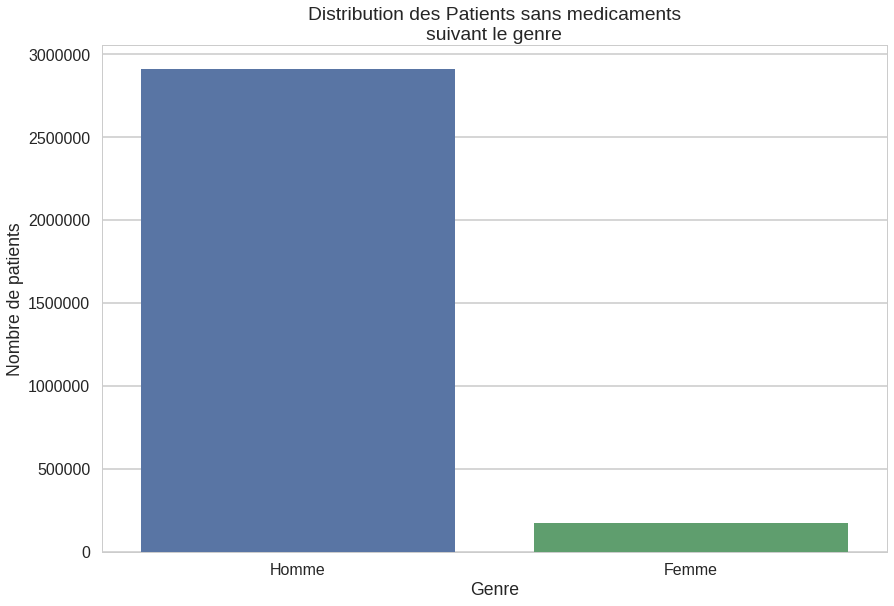

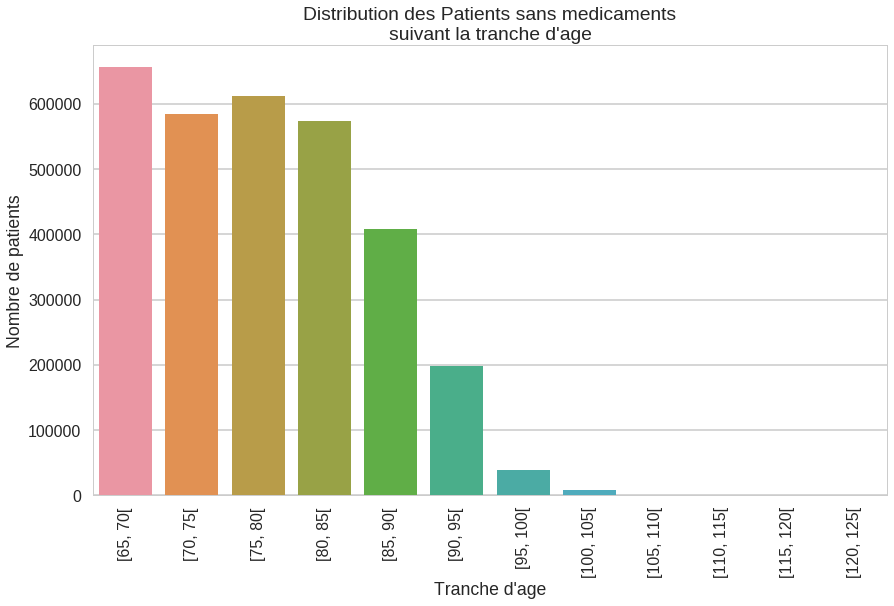

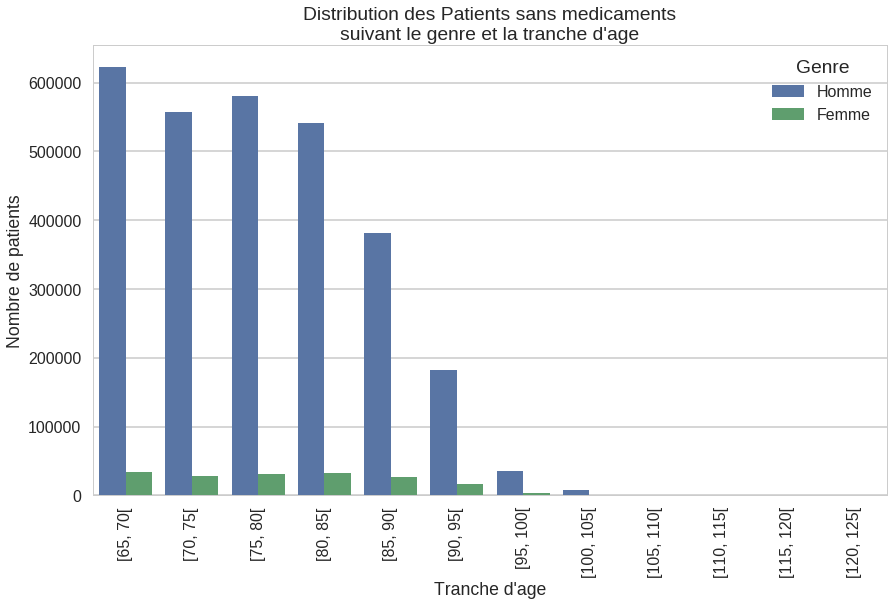

In [10]:
do_save_stats(patients, "Patients sans medicaments")

In [11]:
do_show_stats(patients, "Patients sans medicaments")

Distribution by age bucket of Patients sans medicaments patients.


,ageBucket,count
0,"[65, 70[",656948
1,"[70, 75[",585126
2,"[75, 80[",611463
3,"[80, 85[",573455
4,"[85, 90[",407626
5,"[90, 95[",199036
6,"[95, 100[",38903
7,"[100, 105[",8299
8,"[105, 110[",623
9,"[110, 115[",24


Distribution by gender of Patients sans medicaments patients.


,gender,count
0,1,2907691
1,2,173818


Distribution by gender and age bucket of Patients sans medicaments patients.


,gender,ageBucket,count
0,1,"[65, 70[",623080
1,1,"[70, 75[",556571
2,1,"[75, 80[",580636
3,1,"[80, 85[",540742
4,1,"[85, 90[",380796
5,1,"[90, 95[",182864
6,1,"[95, 100[",35189
7,1,"[100, 105[",7249
8,1,"[105, 110[",543
9,1,"[110, 115[",20


# Patients with fracture 

In [12]:
do_show_stats(affected_patients, "patients avec au moins une fracture")

Distribution by age bucket of patients avec au moins une fracture patients.


,ageBucket,count
0,"[65, 70[",2318
1,"[70, 75[",2524
2,"[75, 80[",3774
3,"[80, 85[",5522
4,"[85, 90[",6403
5,"[90, 95[",4530
6,"[95, 100[",1252
7,"[100, 105[",293
8,"[105, 110[",22


Distribution by gender of patients avec au moins une fracture patients.


,gender,count
0,1,23822
1,2,2816


Distribution by gender and age bucket of patients avec au moins une fracture patients.


,gender,ageBucket,count
0,1,"[65, 70[",2112
1,1,"[70, 75[",2301
2,1,"[75, 80[",3429
3,1,"[80, 85[",4973
4,1,"[85, 90[",5711
5,1,"[90, 95[",3965
6,1,"[95, 100[",1076
7,1,"[100, 105[",238
8,1,"[105, 110[",17
9,2,"[65, 70[",206


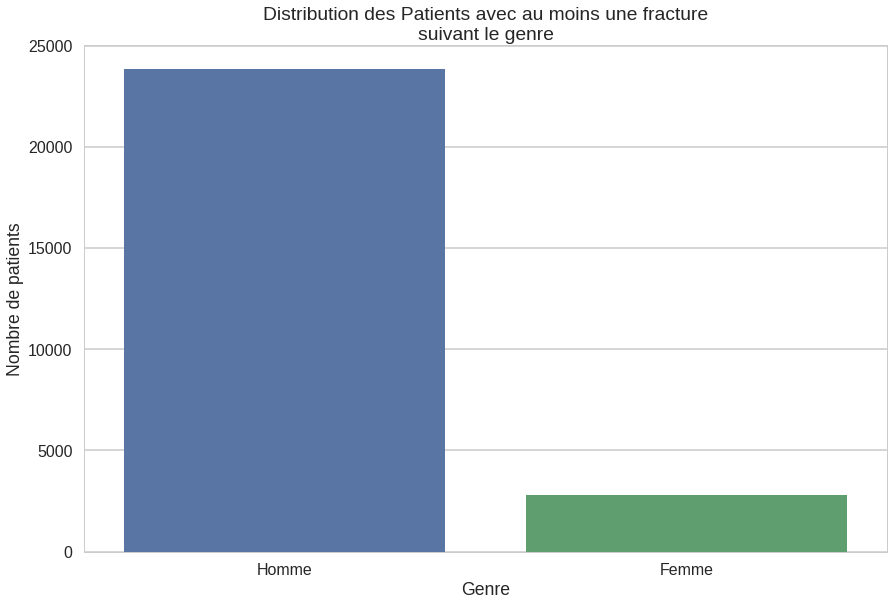

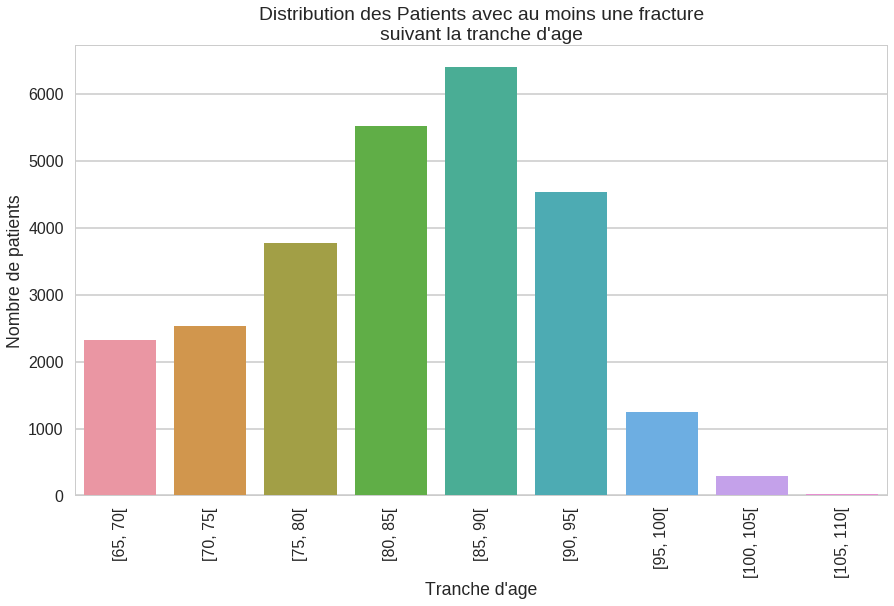

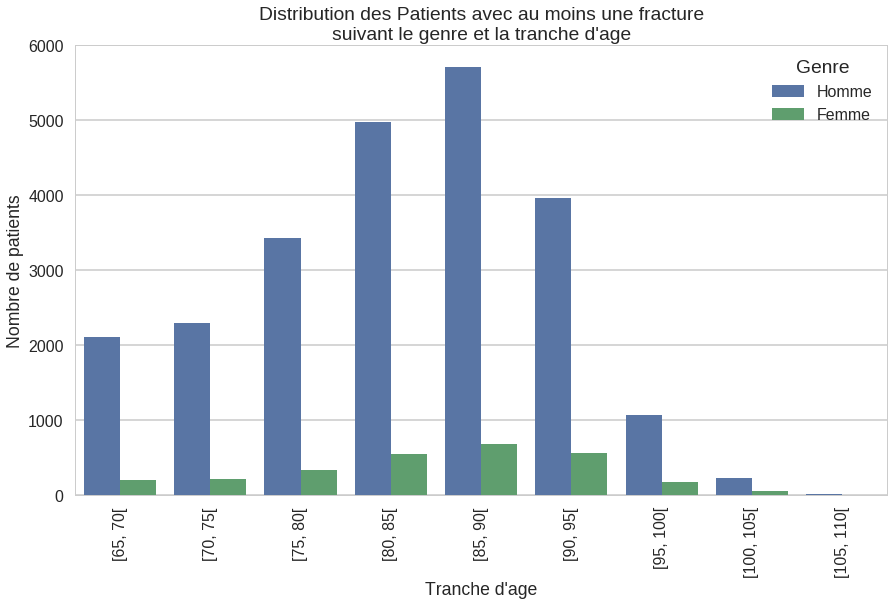

In [13]:
do_save_stats(affected_patients, "Patients avec au moins une fracture")

# With minimum one drug class consumption

In [14]:
drug_classes = ["Antihypertenseurs", "Antidepresseurs", "Hypnotiques", "Neuroleptiques"]

for drug_class in drug_classes:
    targetPatients = patients.join(drugs.where(fn.col("value") == drug_class).select("patientID").distinct(), "patientID")
    do_show_stats(targetPatients, "patients that consumed at least one {} drug".format(drug_class))

Distribution by age bucket of patients that consumed at least one Antihypertenseurs drug patients.


,ageBucket,count
0,"[65, 70[",206612
1,"[70, 75[",236955
2,"[75, 80[",298441
3,"[80, 85[",320249
4,"[85, 90[",242474
5,"[90, 95[",119548
6,"[95, 100[",22906
7,"[100, 105[",4631
8,"[105, 110[",281
9,"[110, 115[",5


Distribution by gender of patients that consumed at least one Antihypertenseurs drug patients.


,gender,count
0,1,1385937
1,2,66166


Distribution by gender and age bucket of patients that consumed at least one Antihypertenseurs drug patients.


,gender,ageBucket,count
0,1,"[65, 70[",197289
1,1,"[70, 75[",227309
2,1,"[75, 80[",286539
3,1,"[80, 85[",306427
4,1,"[85, 90[",230401
5,1,"[90, 95[",112378
6,1,"[95, 100[",21225
7,1,"[100, 105[",4117
8,1,"[105, 110[",247
9,1,"[110, 115[",4


Distribution by age bucket of patients that consumed at least one Antidepresseurs drug patients.


,ageBucket,count
0,"[65, 70[",52940
1,"[70, 75[",49217
2,"[75, 80[",59571
3,"[80, 85[",67806
4,"[85, 90[",59487
5,"[90, 95[",33455
6,"[95, 100[",7177
7,"[100, 105[",1466
8,"[105, 110[",86
9,"[110, 115[",2


Distribution by gender of patients that consumed at least one Antidepresseurs drug patients.


,gender,count
0,1,299896
1,2,31312


Distribution by gender and age bucket of patients that consumed at least one Antidepresseurs drug patients.


,gender,ageBucket,count
0,1,"[65, 70[",47425
1,1,"[70, 75[",44619
2,1,"[75, 80[",54393
3,1,"[80, 85[",62007
4,1,"[85, 90[",53937
5,1,"[90, 95[",29879
6,1,"[95, 100[",6334
7,1,"[100, 105[",1229
8,1,"[105, 110[",70
9,1,"[110, 115[",2


Distribution by age bucket of patients that consumed at least one Hypnotiques drug patients.


,ageBucket,count
0,"[65, 70[",120674
1,"[70, 75[",121721
2,"[75, 80[",146538
3,"[80, 85[",155177
4,"[85, 90[",124140
5,"[90, 95[",65202
6,"[95, 100[",13541
7,"[100, 105[",2948
8,"[105, 110[",187
9,"[110, 115[",4


Distribution by gender of patients that consumed at least one Hypnotiques drug patients.


,gender,count
0,1,696889
1,2,53244


Distribution by gender and age bucket of patients that consumed at least one Hypnotiques drug patients.


,gender,ageBucket,count
0,1,"[65, 70[",111436
1,1,"[70, 75[",113535
2,1,"[75, 80[",137241
3,1,"[80, 85[",144826
4,1,"[85, 90[",115226
5,1,"[90, 95[",59709
6,1,"[95, 100[",12227
7,1,"[100, 105[",2519
8,1,"[105, 110[",165
9,1,"[110, 115[",4


Distribution by age bucket of patients that consumed at least one Neuroleptiques drug patients.


,ageBucket,count
0,"[65, 70[",13107
1,"[70, 75[",11929
2,"[75, 80[",14889
3,"[80, 85[",16980
4,"[85, 90[",16133
5,"[90, 95[",9921
6,"[95, 100[",2690
7,"[100, 105[",698
8,"[105, 110[",48
9,"[110, 115[",1


Distribution by gender of patients that consumed at least one Neuroleptiques drug patients.


,gender,count
0,1,79607
1,2,6790


Distribution by gender and age bucket of patients that consumed at least one Neuroleptiques drug patients.


,gender,ageBucket,count
0,1,"[65, 70[",12246
1,1,"[70, 75[",11062
2,1,"[75, 80[",13887
3,1,"[80, 85[",15739
4,1,"[85, 90[",14788
5,1,"[90, 95[",8883
6,1,"[95, 100[",2388
7,1,"[100, 105[",576
8,1,"[105, 110[",36
9,1,"[110, 115[",1


In [15]:
def do_save_stats_with_drugs(patients, drug_class):
    targetPatients = patients.join(drugs.where(fn.col("value") == drug_class).select("patientID").distinct(), "patientID")
    do_save_stats(targetPatients, "Patients ayant achete de {}".format(drug_class))

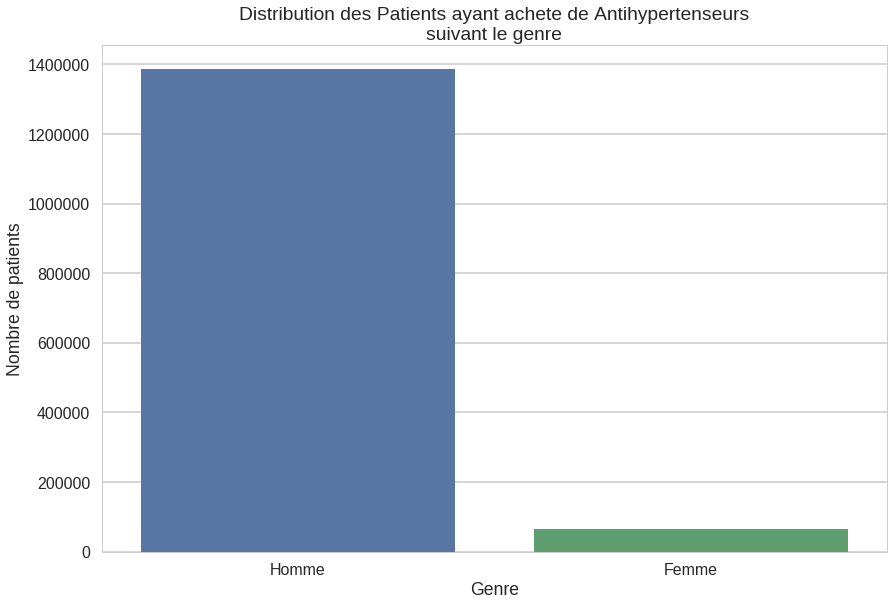

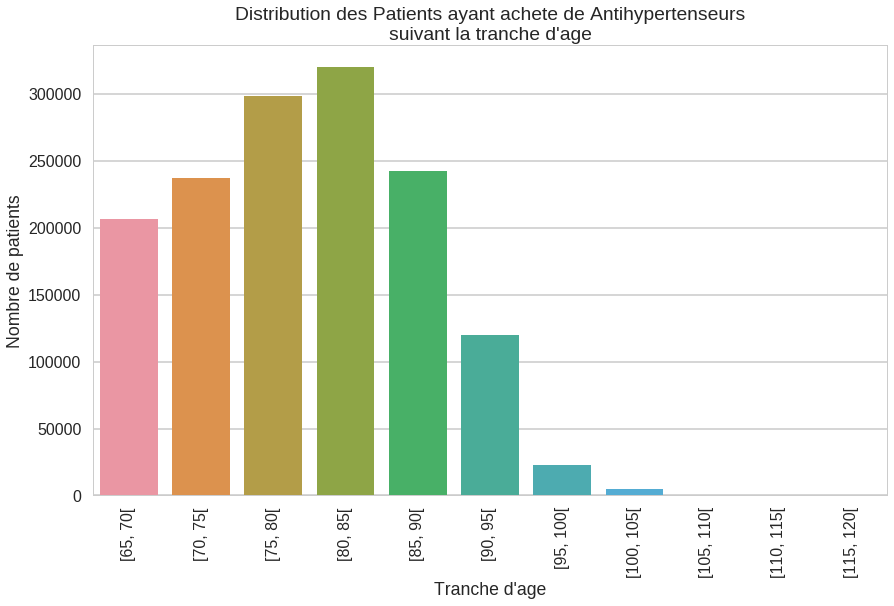

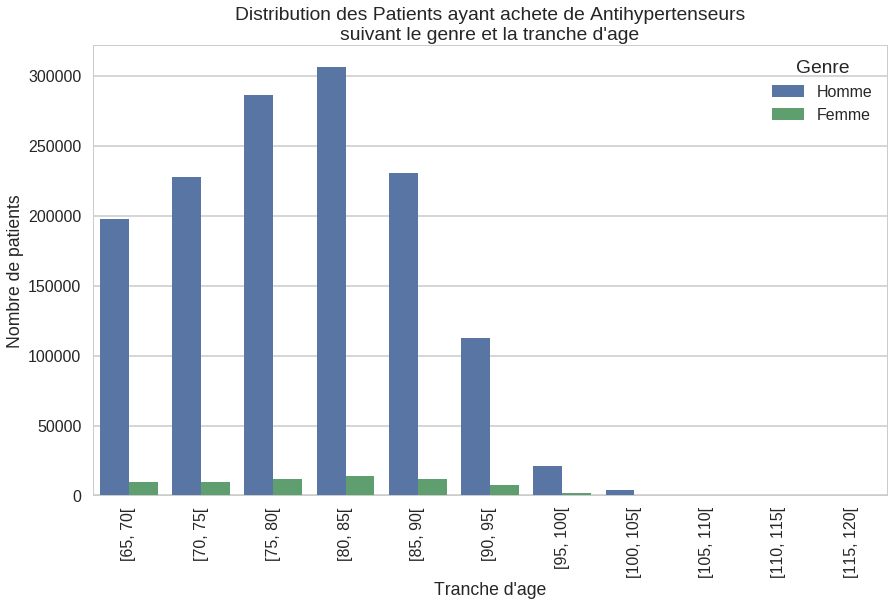

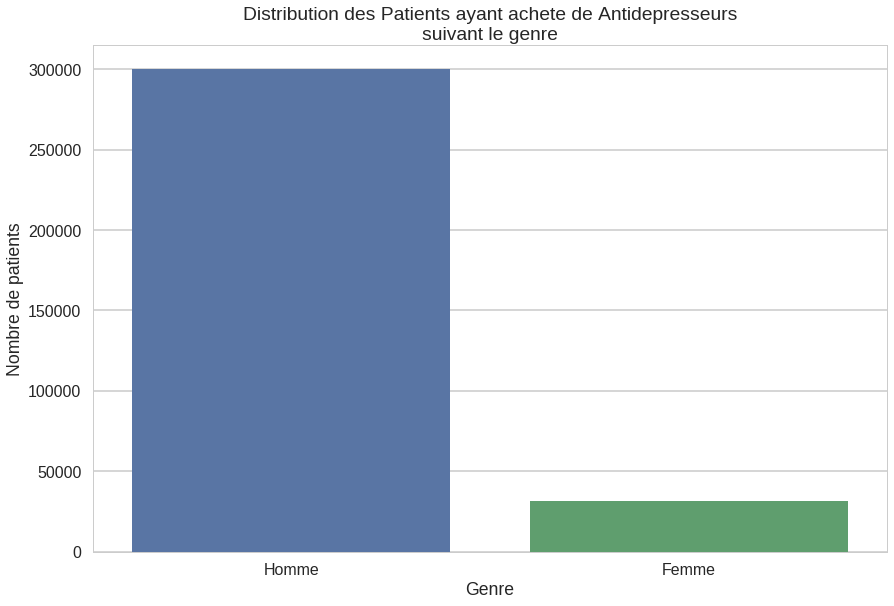

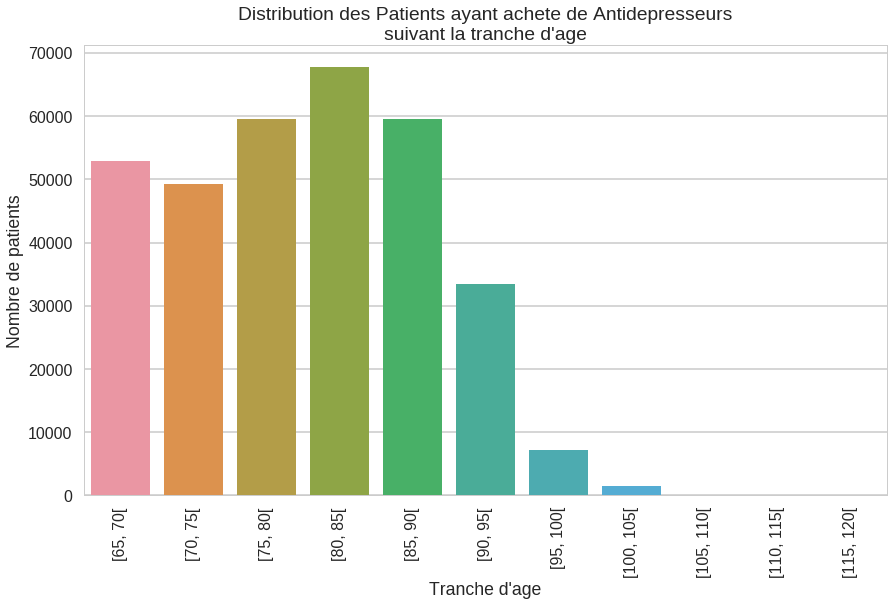

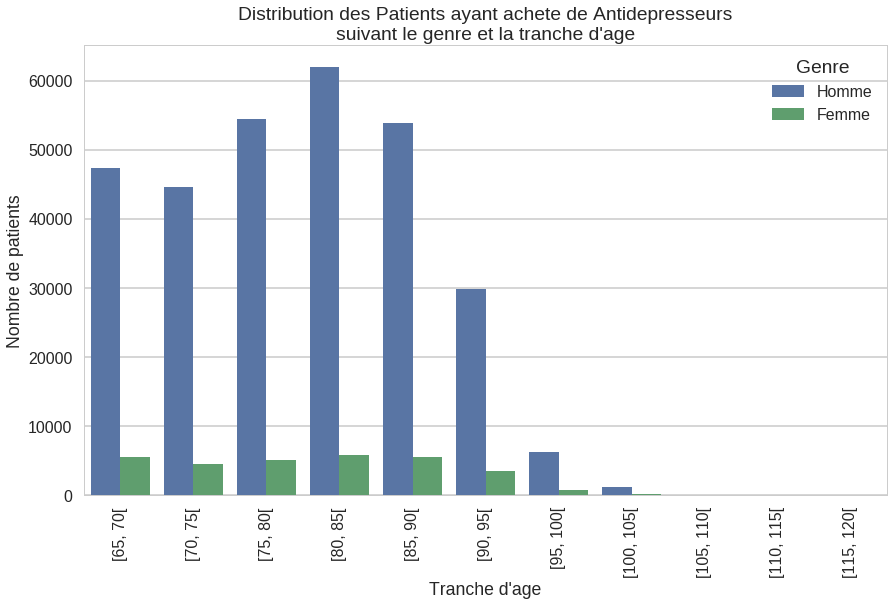

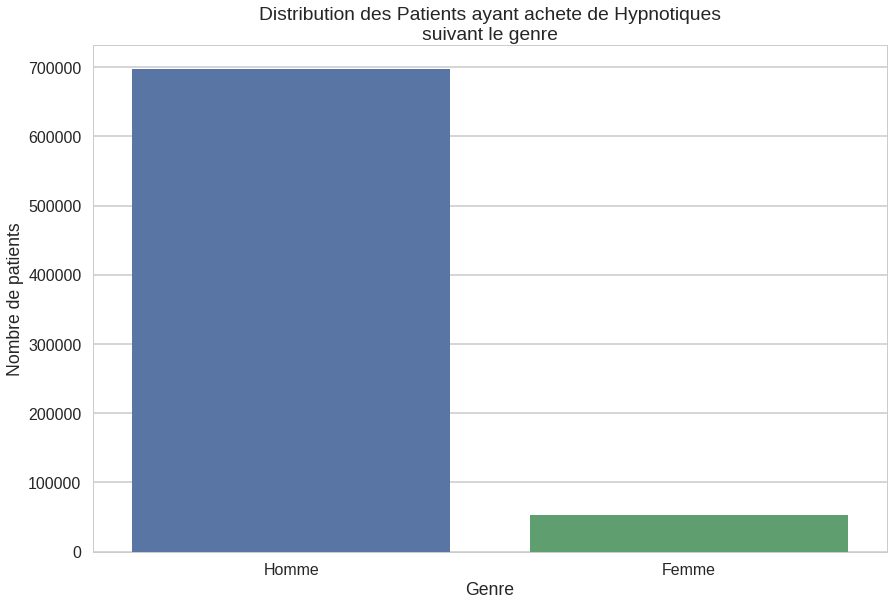

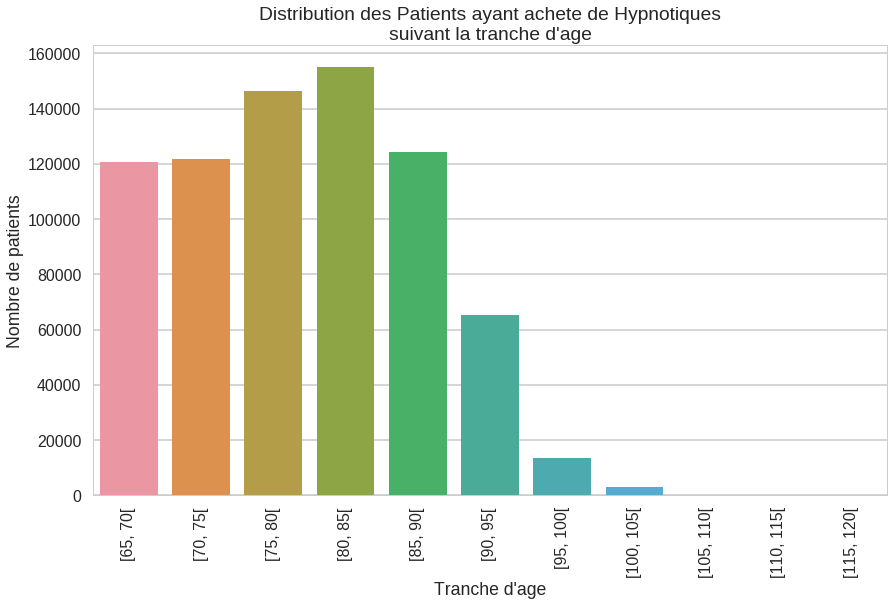

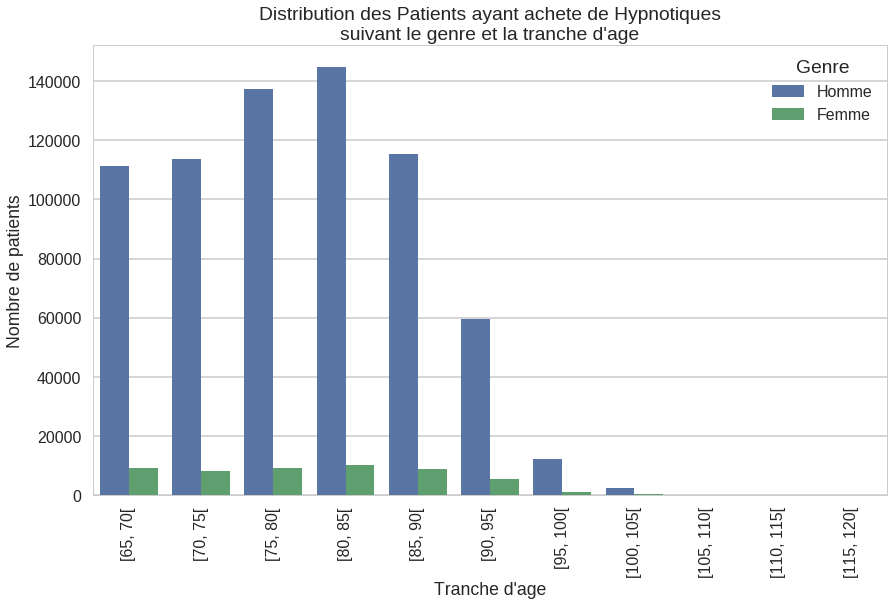

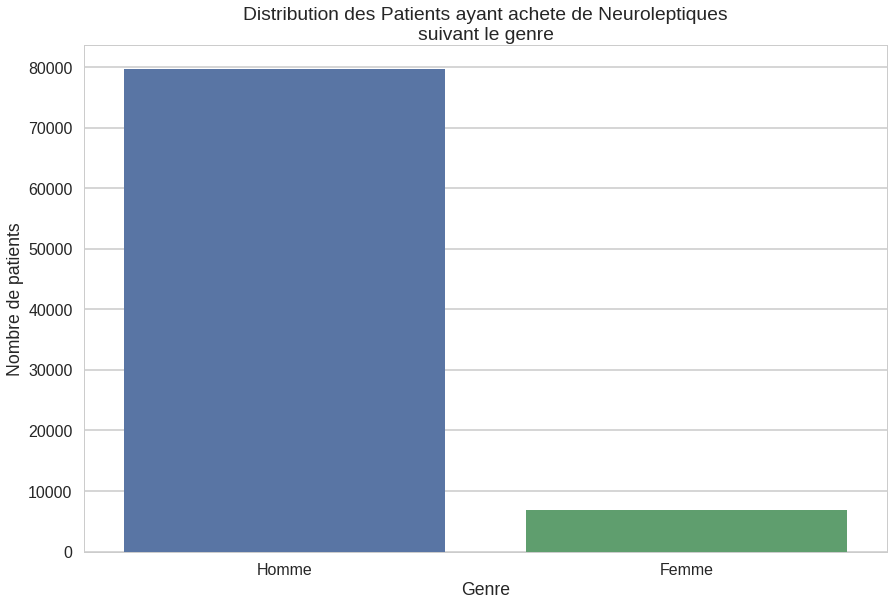

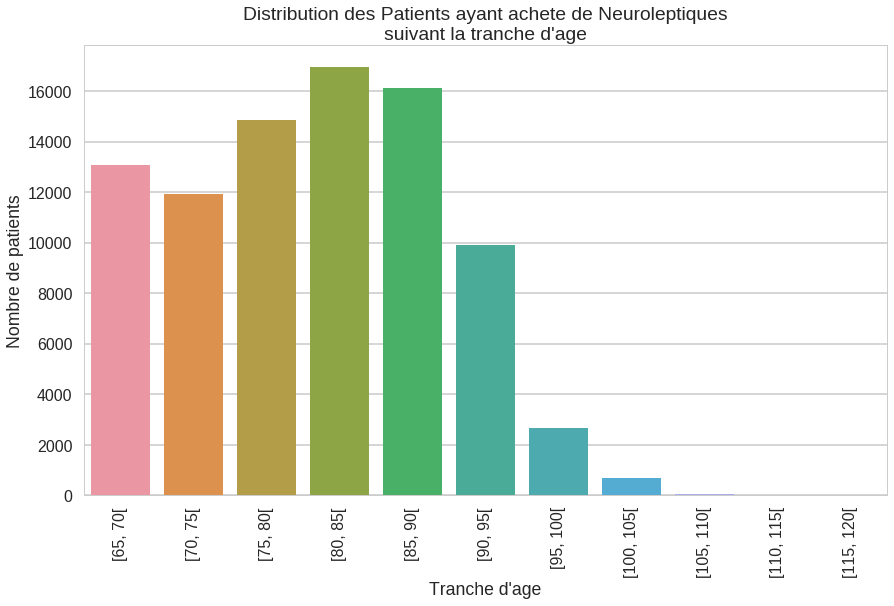

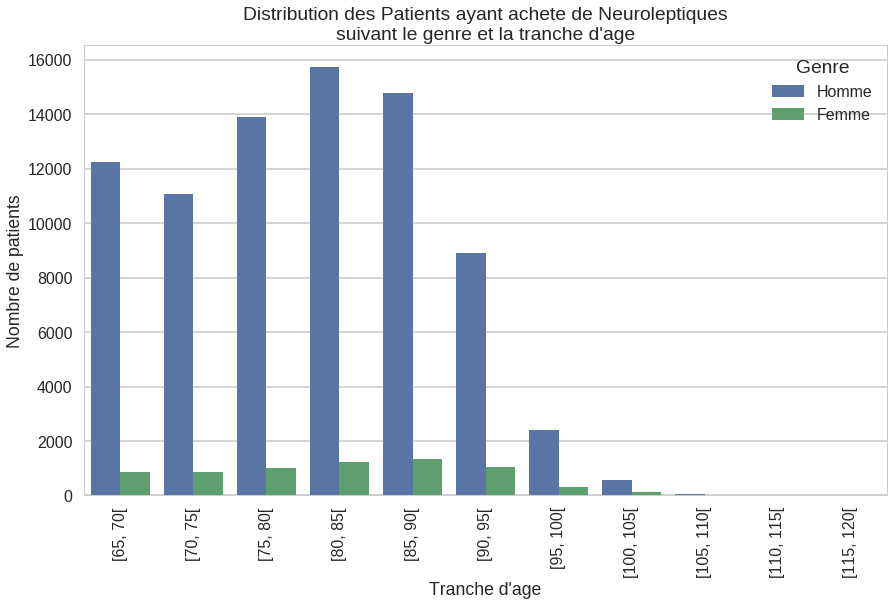

In [16]:
drug_classes = ["Antihypertenseurs", "Antidepresseurs", "Hypnotiques", "Neuroleptiques"]
for drug_class in drug_classes:
    do_save_stats_with_drugs(patients, drug_class)

# With a fracture and a consumption of a class of drugs 

In [17]:
drug_classes = ["Antihypertenseurs", "Antidepresseurs", "Hypnotiques", "Neuroleptiques"]

for drug_class in drug_classes:
    targetPatients = affected_patients.join(drugs.where(fn.col("value") == drug_class).select("patientID").distinct(), "patientID")
    do_show_stats(targetPatients, "patients that consumed at least one {} drug and a fracture".format(drug_class))

Distribution by age bucket of patients that consumed at least one Antihypertenseurs drug and a fracture patients.


,ageBucket,count
0,"[65, 70[",1122
1,"[70, 75[",1551
2,"[75, 80[",2517
3,"[80, 85[",3969
4,"[85, 90[",4664
5,"[90, 95[",3306
6,"[95, 100[",869
7,"[100, 105[",195
8,"[105, 110[",17


Distribution by gender of patients that consumed at least one Antihypertenseurs drug and a fracture patients.


,gender,count
0,1,16240
1,2,1970


Distribution by gender and age bucket of patients that consumed at least one Antihypertenseurs drug and a fracture patients.


,gender,ageBucket,count
0,1,"[65, 70[",1034
1,1,"[70, 75[",1412
2,1,"[75, 80[",2301
3,1,"[80, 85[",3576
4,1,"[85, 90[",4151
5,1,"[90, 95[",2869
6,1,"[95, 100[",726
7,1,"[100, 105[",158
8,1,"[105, 110[",13
9,2,"[65, 70[",88


Distribution by age bucket of patients that consumed at least one Antidepresseurs drug and a fracture patients.


,ageBucket,count
0,"[65, 70[",559
1,"[70, 75[",625
2,"[75, 80[",1041
3,"[80, 85[",1676
4,"[85, 90[",2148
5,"[90, 95[",1589
6,"[95, 100[",423
7,"[100, 105[",83
8,"[105, 110[",8


Distribution by gender of patients that consumed at least one Antidepresseurs drug and a fracture patients.


,gender,count
0,1,6859
1,2,1293


Distribution by gender and age bucket of patients that consumed at least one Antidepresseurs drug and a fracture patients.


,gender,ageBucket,count
0,1,"[65, 70[",475
1,1,"[70, 75[",531
2,1,"[75, 80[",898
3,1,"[80, 85[",1425
4,1,"[85, 90[",1803
5,1,"[90, 95[",1322
6,1,"[95, 100[",337
7,1,"[100, 105[",61
8,1,"[105, 110[",7
9,2,"[65, 70[",84


Distribution by age bucket of patients that consumed at least one Hypnotiques drug and a fracture patients.


,ageBucket,count
0,"[65, 70[",1015
1,"[70, 75[",1175
2,"[75, 80[",1911
3,"[80, 85[",2815
4,"[85, 90[",3356
5,"[90, 95[",2423
6,"[95, 100[",665
7,"[100, 105[",149
8,"[105, 110[",11


Distribution by gender of patients that consumed at least one Hypnotiques drug and a fracture patients.


,gender,count
0,1,11708
1,2,1812


Distribution by gender and age bucket of patients that consumed at least one Hypnotiques drug and a fracture patients.


,gender,ageBucket,count
0,1,"[65, 70[",897
1,1,"[70, 75[",1045
2,1,"[75, 80[",1691
3,1,"[80, 85[",2465
4,1,"[85, 90[",2898
5,1,"[90, 95[",2043
6,1,"[95, 100[",549
7,1,"[100, 105[",112
8,1,"[105, 110[",8
9,2,"[65, 70[",118


Distribution by age bucket of patients that consumed at least one Neuroleptiques drug and a fracture patients.


,ageBucket,count
0,"[65, 70[",169
1,"[70, 75[",167
2,"[75, 80[",339
3,"[80, 85[",528
4,"[85, 90[",680
5,"[90, 95[",507
6,"[95, 100[",163
7,"[100, 105[",32
8,"[105, 110[",5


Distribution by gender of patients that consumed at least one Neuroleptiques drug and a fracture patients.


,gender,count
0,1,2215
1,2,375


Distribution by gender and age bucket of patients that consumed at least one Neuroleptiques drug and a fracture patients.


,gender,ageBucket,count
0,1,"[65, 70[",145
1,1,"[70, 75[",152
2,1,"[75, 80[",303
3,1,"[80, 85[",451
4,1,"[85, 90[",574
5,1,"[90, 95[",424
6,1,"[95, 100[",136
7,1,"[100, 105[",26
8,1,"[105, 110[",4
9,2,"[65, 70[",24


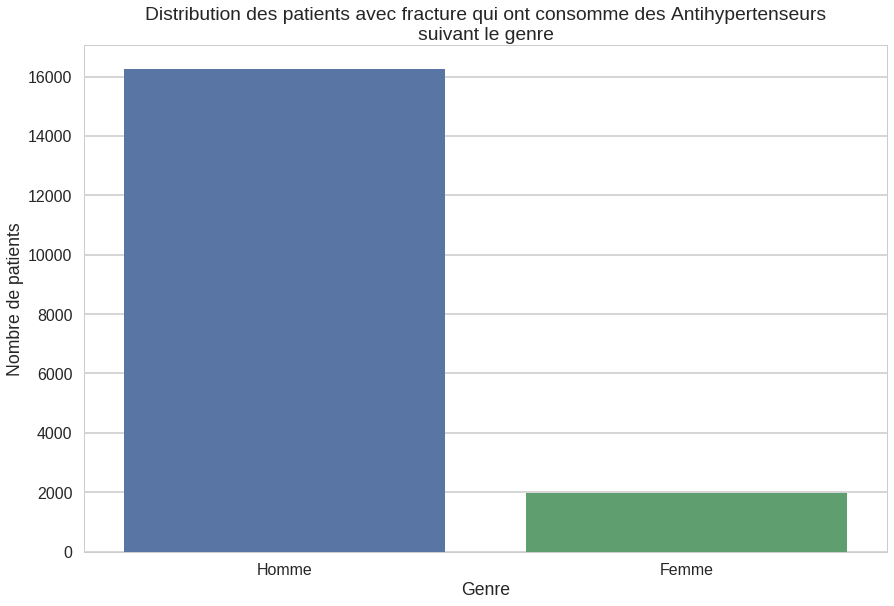

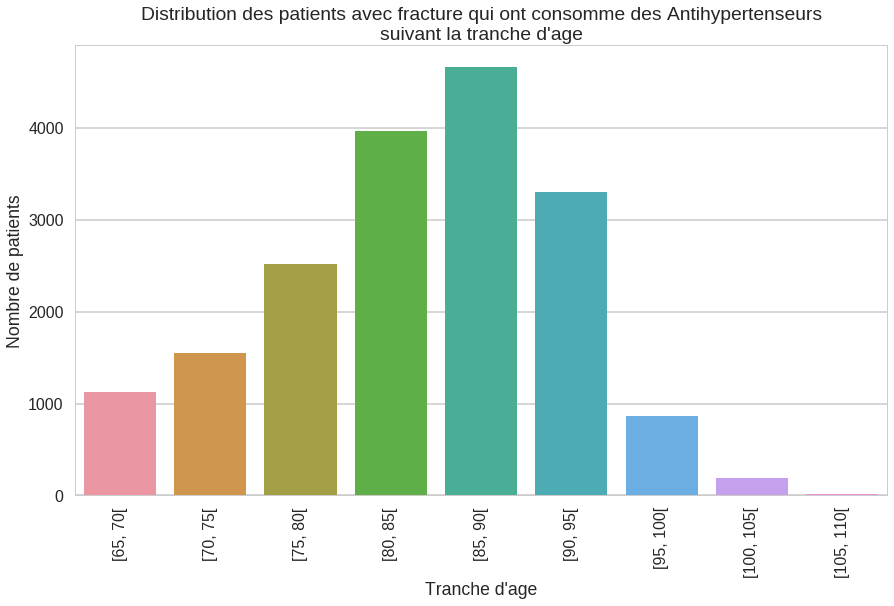

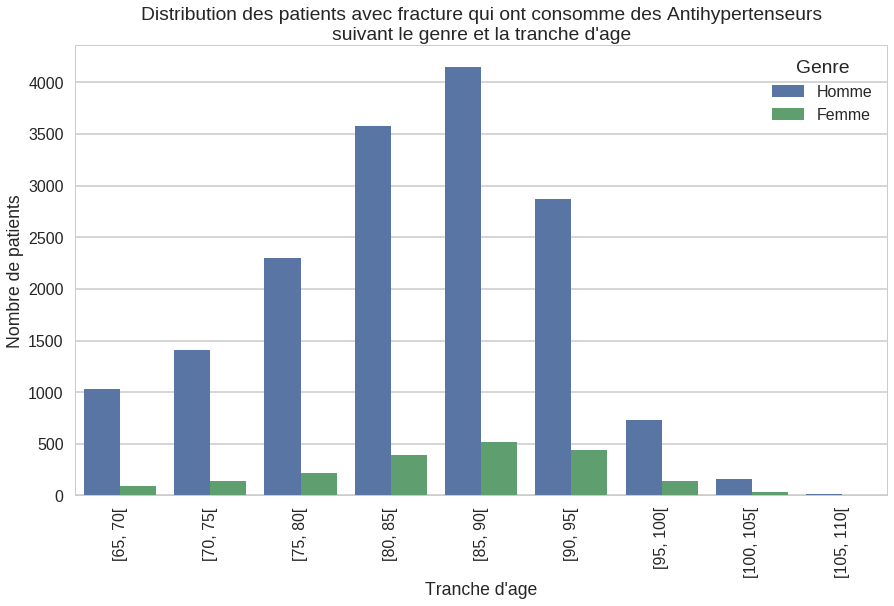

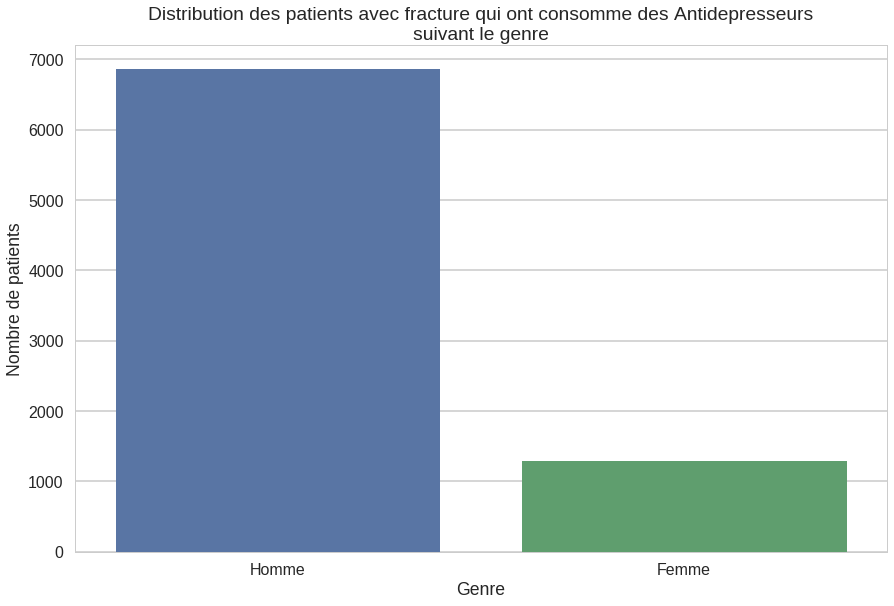

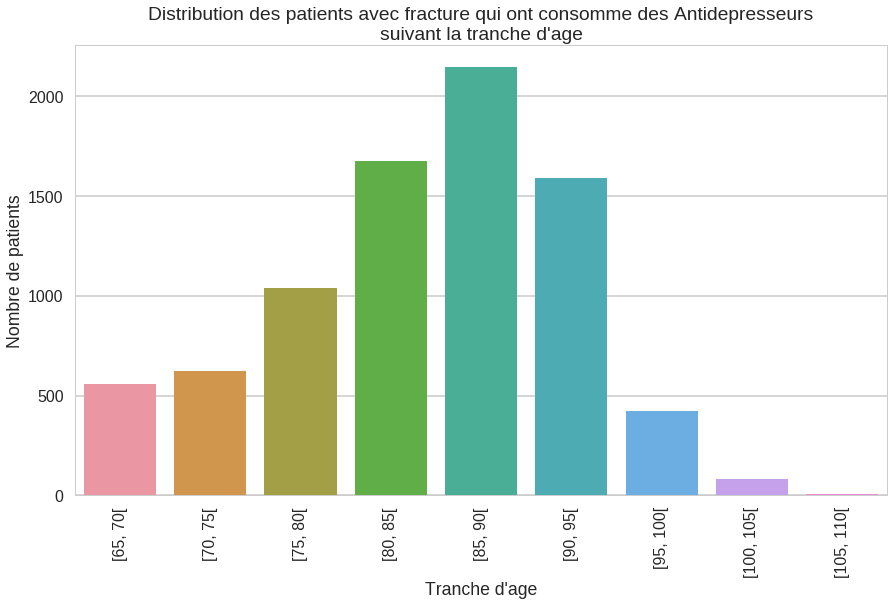

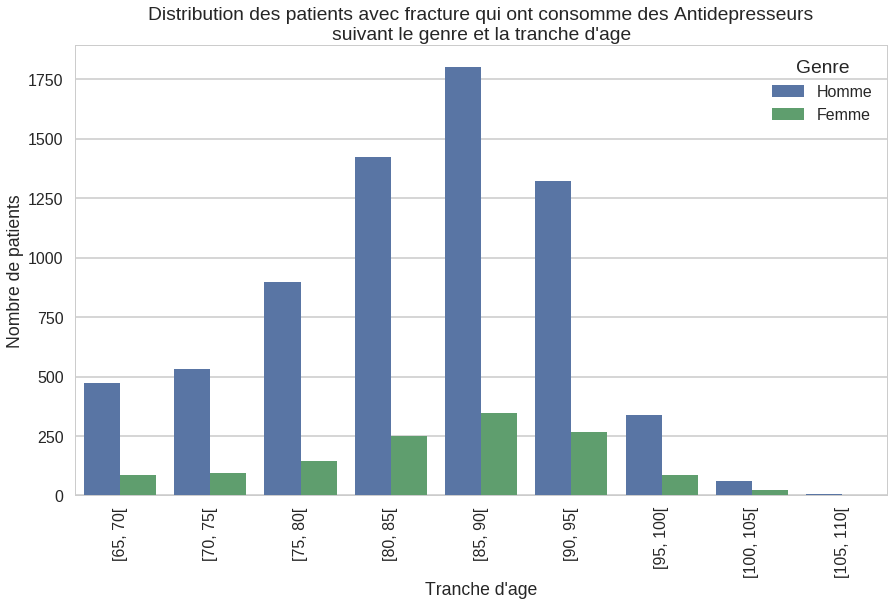

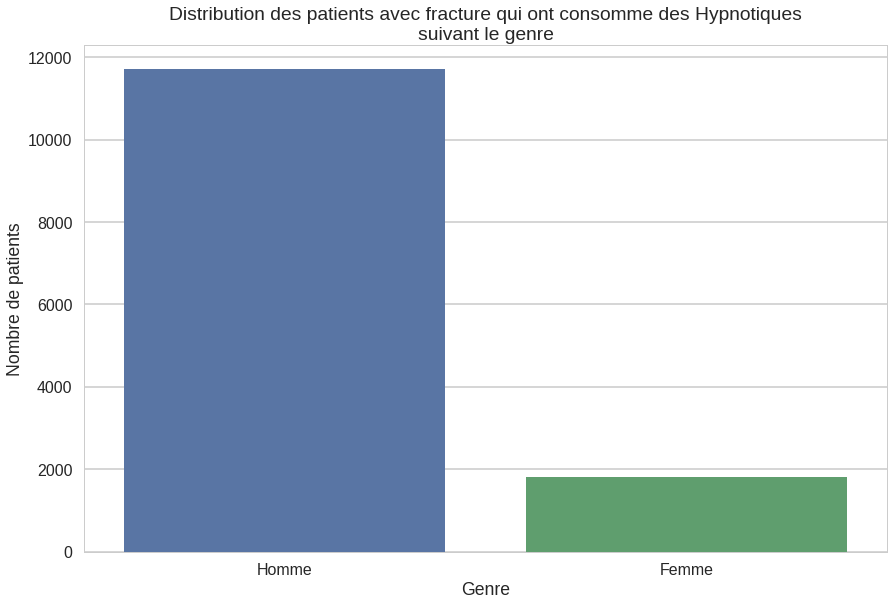

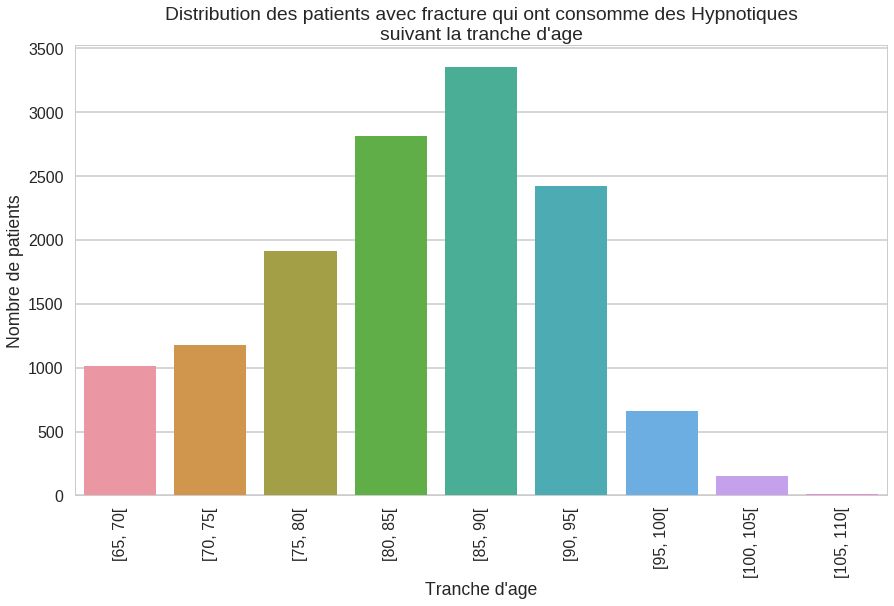

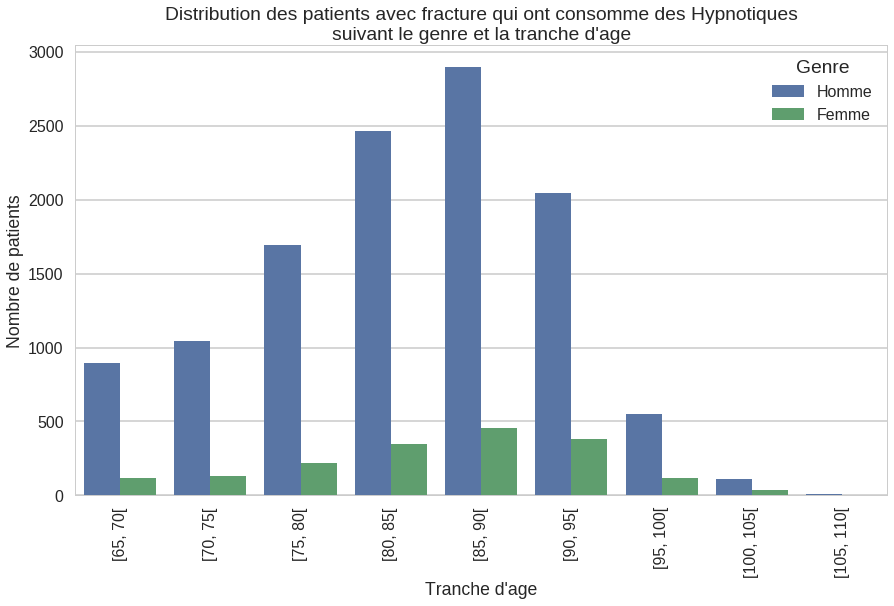

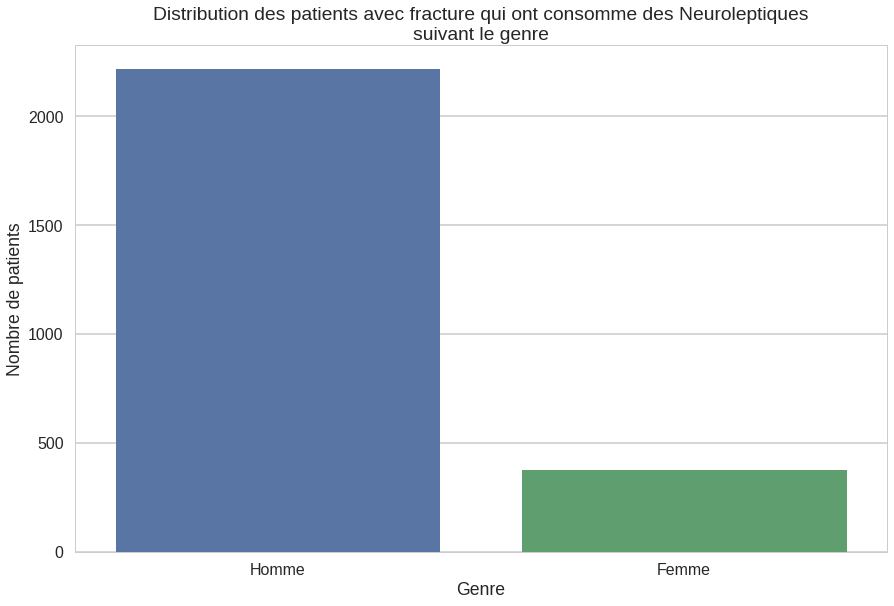

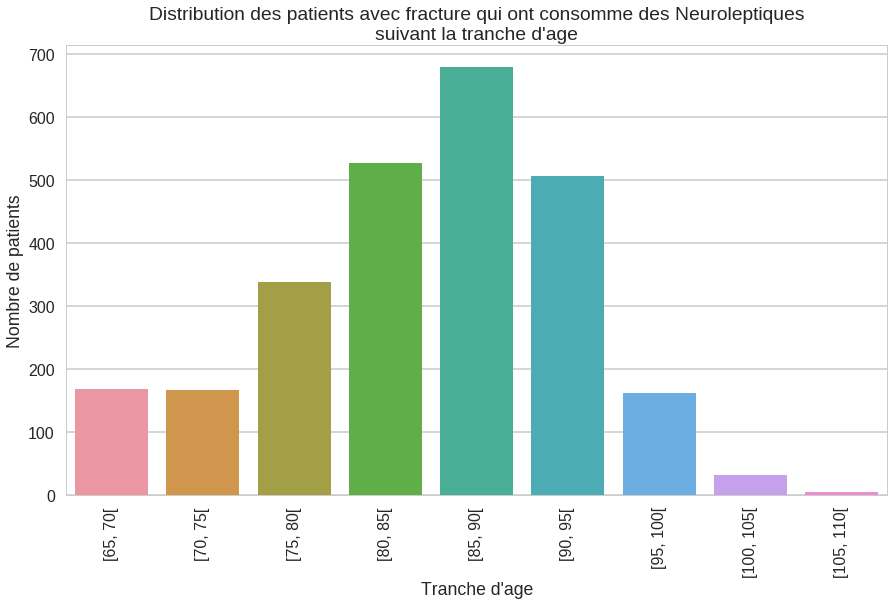

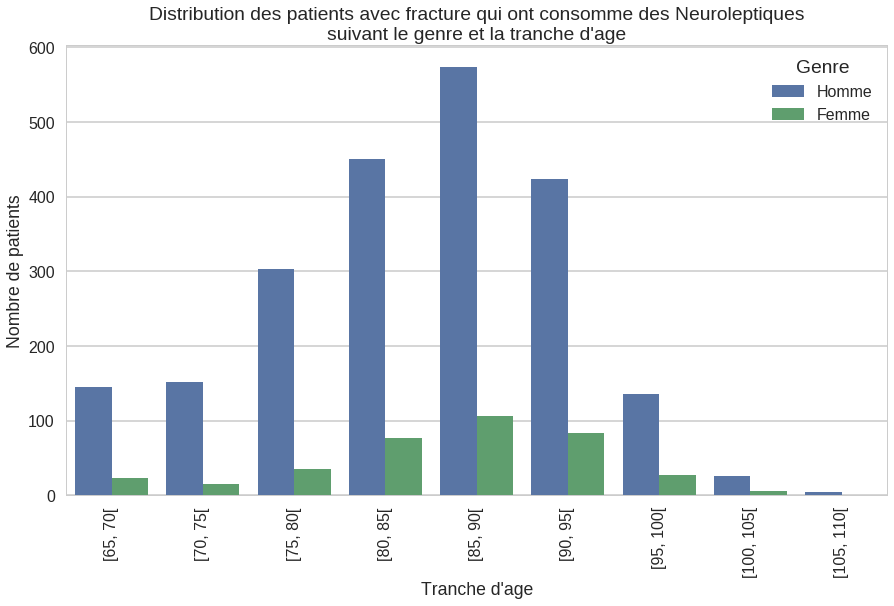

In [18]:
drug_classes = ["Antihypertenseurs", "Antidepresseurs", "Hypnotiques", "Neuroleptiques"]
for drug_class in drug_classes:
    targetPatients = affected_patients.join(drugs.where(fn.col("value") == drug_class).select("patientID").distinct(), "patientID")
    do_save_stats(targetPatients, "patients avec fracture qui ont consomme des {}".format(drug_class))